In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
train_input = train_input + val_input
train_output = train_output + val_output

In [22]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [23]:
integrade_data_raw = pd.read_csv('gex.combined.sct.csv')
integrade_meta_raw = pd.read_csv('gex.combined.sct.obs.csv')

In [24]:
integrade_data = integrade_data_raw
integrade_meta = integrade_meta_raw

In [25]:
integrade_data = integrade_data.transpose()

In [26]:
integrade_data = integrade_data.iloc[1:, :]

In [ ]:
integrade_data
integrade_data.to_pickle("./seurat_inte.pkl")

In [ ]:
integrade_data = pd.read_pickle("./seurat_inte.pkl")

In [27]:
integrade_data.reset_index(drop=True, inplace=True)
integrade_data['batch'] = integrade_meta['batch']

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s4d1', 's4d8', 's4d9']

In [28]:
s1d1_integrade_data = integrade_data[integrade_data['batch'] == 's1d1']
s1d2_integrade_data = integrade_data[integrade_data['batch'] == 's1d2']
s1d3_integrade_data = integrade_data[integrade_data['batch'] == 's1d3']
s2d1_integrade_data = integrade_data[integrade_data['batch'] == 's2d1']
s2d4_integrade_data = integrade_data[integrade_data['batch'] == 's2d4']
s2d5_integrade_data = integrade_data[integrade_data['batch'] == 's2d5']
s3d1_integrade_data = integrade_data[integrade_data['batch'] == 's3d1']
s3d6_integrade_data = integrade_data[integrade_data['batch'] == 's3d6']
s3d7_integrade_data = integrade_data[integrade_data['batch'] == 's3d7']

In [29]:
s4d1_integrade_data = integrade_data[integrade_data['batch'] == 's4d1']
s4d8_integrade_data = integrade_data[integrade_data['batch'] == 's4d8']
s4d9_integrade_data = integrade_data[integrade_data['batch'] == 's4d9']

In [30]:
s1d1_inte_np = s1d1_integrade_data.iloc[:, :-1].to_numpy()
s1d2_inte_np = s1d2_integrade_data.iloc[:, :-1].to_numpy()
s1d3_inte_np = s1d3_integrade_data.iloc[:, :-1].to_numpy()
s2d1_inte_np = s2d1_integrade_data.iloc[:, :-1].to_numpy()
s2d4_inte_np = s2d4_integrade_data.iloc[:, :-1].to_numpy()
s2d5_inte_np = s2d5_integrade_data.iloc[:, :-1].to_numpy()
s3d1_inte_np = s3d1_integrade_data.iloc[:, :-1].to_numpy()
s3d6_inte_np = s3d6_integrade_data.iloc[:, :-1].to_numpy()
s3d7_inte_np = s3d7_integrade_data.iloc[:, :-1].to_numpy()

In [31]:
s4d1_inte_np = s4d1_integrade_data.iloc[:, :-1].to_numpy()
s4d8_inte_np = s4d8_integrade_data.iloc[:, :-1].to_numpy()
s4d9_inte_np = s4d9_integrade_data.iloc[:, :-1].to_numpy()

In [32]:
train_input_inte = np.concatenate([s1d1_inte_np, s1d2_inte_np, s1d3_inte_np, s2d1_inte_np, s2d4_inte_np, s2d5_inte_np, s3d1_inte_np, s3d6_inte_np, s3d7_inte_np], axis=0)
val_input_inte = np.concatenate([s3d1_inte_np, s3d6_inte_np, s3d7_inte_np], axis=0)
test_input_inte = np.concatenate([s4d1_inte_np, s4d8_inte_np, s4d9_inte_np], axis=0)

In [33]:
train_input = np.concatenate([train_input, train_input_inte], axis=1)
val_input = np.concatenate([val_input, val_input_inte], axis=1)
test_input = np.concatenate([test_input, test_input_inte], axis=1)

In [34]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

(66175, 16953)
(28921, 16953)
(1000, 16953)


In [35]:
train_input = np.float64(train_input)
val_input = np.float64(val_input)
test_input = np.float64(test_input)

In [36]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [37]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [38]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [39]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [40]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [41]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [42]:
batch_train = batch_train + batch_val

In [43]:
train_output = train_output[:, pred_num:pred_num+1]
train_output.shape

torch.Size([66175, 1])

In [44]:
val_output = val_output[:, pred_num:pred_num+1]
val_output.shape

torch.Size([28921, 1])

In [45]:
test_output = test_output[:, pred_num:pred_num+1]
test_output.shape

torch.Size([1000, 1])

In [46]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [47]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [48]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [49]:
PATH = 'No_norm_model_RNA_pro_with_inte'

In [50]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 500 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (10, 4*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.5157873  Validation_loss:  0.3588394  Test_loss:  0.6750394


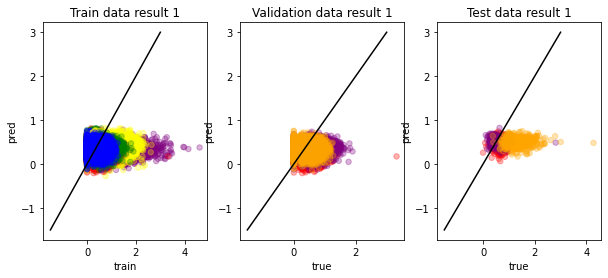

Epoch  100 Train_loss:  0.36940914  Validation_loss:  0.28396487  Test_loss:  0.73537225
Epoch  200 Train_loss:  0.3439232  Validation_loss:  0.27010825  Test_loss:  0.7251097
Epoch  300 Train_loss:  0.32522133  Validation_loss:  0.26157784  Test_loss:  0.7235993
Epoch  400 Train_loss:  0.3096397  Validation_loss:  0.253684  Test_loss:  0.72551477
Epoch  500 Train_loss:  0.2953256  Validation_loss:  0.24588625  Test_loss:  0.72744215


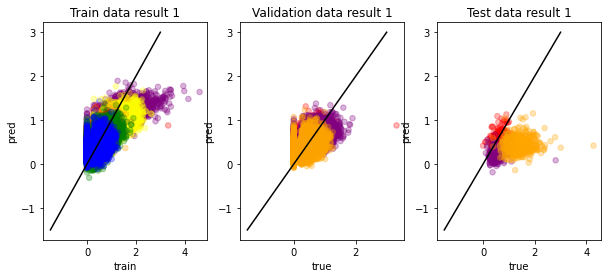

Epoch  600 Train_loss:  0.2813581  Validation_loss:  0.23674224  Test_loss:  0.73413247
Epoch  700 Train_loss:  0.26728576  Validation_loss:  0.22696462  Test_loss:  0.74403244
Epoch  800 Train_loss:  0.2528607  Validation_loss:  0.21689674  Test_loss:  0.74942195
Epoch  900 Train_loss:  0.23815964  Validation_loss:  0.20579627  Test_loss:  0.757569
Epoch  1000 Train_loss:  0.22318687  Validation_loss:  0.19450529  Test_loss:  0.7617932


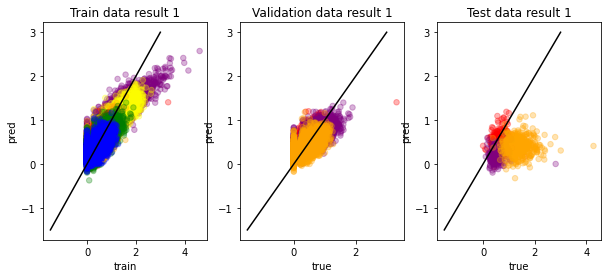

Epoch  1100 Train_loss:  0.20818858  Validation_loss:  0.18286602  Test_loss:  0.76436657
Epoch  1200 Train_loss:  0.19324294  Validation_loss:  0.17095192  Test_loss:  0.7731992
Epoch  1300 Train_loss:  0.17865156  Validation_loss:  0.15905431  Test_loss:  0.77684826
Epoch  1400 Train_loss:  0.16460127  Validation_loss:  0.1474637  Test_loss:  0.7834662
Epoch  1500 Train_loss:  0.15118507  Validation_loss:  0.13638823  Test_loss:  0.7859795


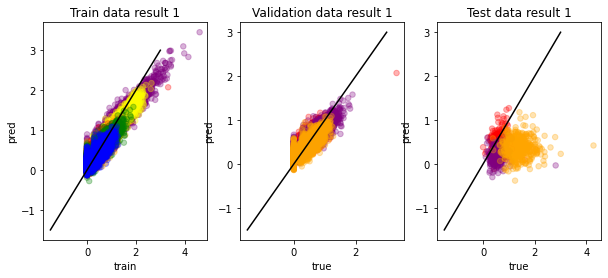

Epoch  1600 Train_loss:  0.13856049  Validation_loss:  0.12569876  Test_loss:  0.7890497
Epoch  1700 Train_loss:  0.12677182  Validation_loss:  0.11572197  Test_loss:  0.78956044
Epoch  1800 Train_loss:  0.11588904  Validation_loss:  0.106377885  Test_loss:  0.79305404
Epoch  1900 Train_loss:  0.10587869  Validation_loss:  0.09760119  Test_loss:  0.7940647
Epoch  2000 Train_loss:  0.09672207  Validation_loss:  0.08965649  Test_loss:  0.7938047


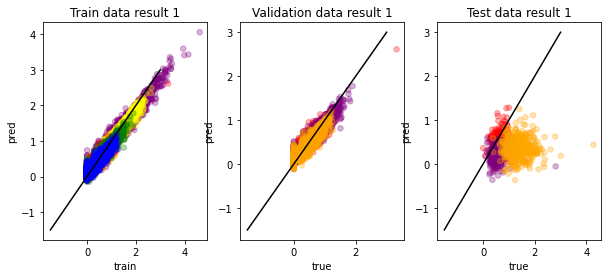

Epoch  2100 Train_loss:  0.0884072  Validation_loss:  0.08224394  Test_loss:  0.7952817
Epoch  2200 Train_loss:  0.08083312  Validation_loss:  0.07551701  Test_loss:  0.7962451
Epoch  2300 Train_loss:  0.07398679  Validation_loss:  0.069330126  Test_loss:  0.79758114
Epoch  2400 Train_loss:  0.06778675  Validation_loss:  0.06374455  Test_loss:  0.7972669
Epoch  2500 Train_loss:  0.06216786  Validation_loss:  0.058692385  Test_loss:  0.79812497


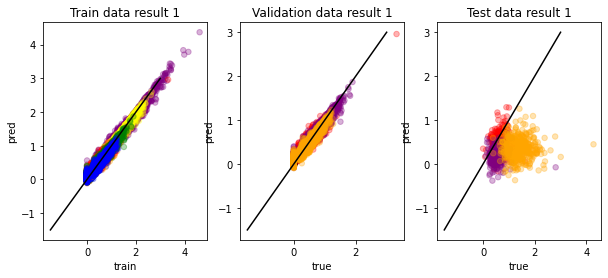

Epoch  2600 Train_loss:  0.057101823  Validation_loss:  0.054054447  Test_loss:  0.79730564
Epoch  2700 Train_loss:  0.052481607  Validation_loss:  0.049816426  Test_loss:  0.79999185
Epoch  2800 Train_loss:  0.048301954  Validation_loss:  0.045964766  Test_loss:  0.7986396
Epoch  2900 Train_loss:  0.044517707  Validation_loss:  0.042473454  Test_loss:  0.7998851
Epoch  3000 Train_loss:  0.0410729  Validation_loss:  0.03929338  Test_loss:  0.79996544


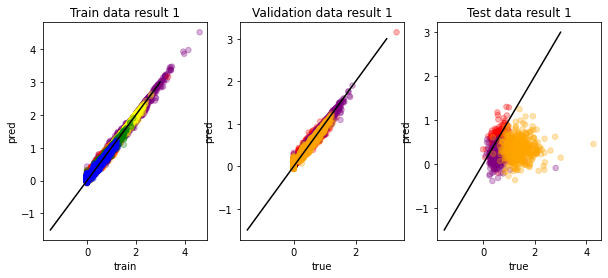

Epoch  3100 Train_loss:  0.037945736  Validation_loss:  0.036390953  Test_loss:  0.8002672
Epoch  3200 Train_loss:  0.03510391  Validation_loss:  0.033757053  Test_loss:  0.8001825
Epoch  3300 Train_loss:  0.03250926  Validation_loss:  0.031375945  Test_loss:  0.80018634
Epoch  3400 Train_loss:  0.030136913  Validation_loss:  0.029153531  Test_loss:  0.80065525
Epoch  3500 Train_loss:  0.027972735  Validation_loss:  0.027137933  Test_loss:  0.80136245


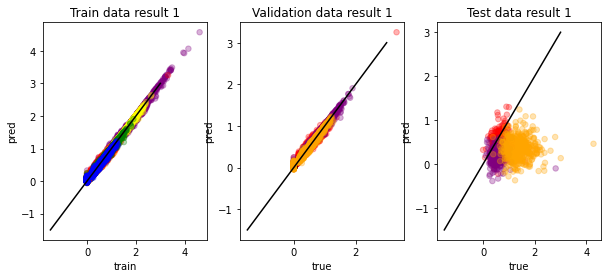

Epoch  3600 Train_loss:  0.025991831  Validation_loss:  0.025273494  Test_loss:  0.8010536
Epoch  3700 Train_loss:  0.024173465  Validation_loss:  0.0235931  Test_loss:  0.80105394
Epoch  3800 Train_loss:  0.022499774  Validation_loss:  0.022044793  Test_loss:  0.80119574
Epoch  3900 Train_loss:  0.020975897  Validation_loss:  0.020611446  Test_loss:  0.80114067
Epoch  4000 Train_loss:  0.01956436  Validation_loss:  0.01931108  Test_loss:  0.8014927


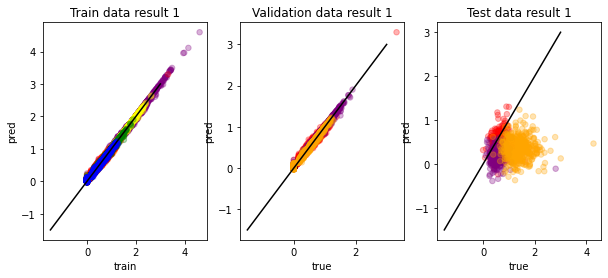

Epoch  4100 Train_loss:  0.018265486  Validation_loss:  0.018073356  Test_loss:  0.8015016
Epoch  4200 Train_loss:  0.017066592  Validation_loss:  0.016963454  Test_loss:  0.8016614
Epoch  4300 Train_loss:  0.01596377  Validation_loss:  0.015924487  Test_loss:  0.8012057
Epoch  4400 Train_loss:  0.014941212  Validation_loss:  0.01498015  Test_loss:  0.80166334
Epoch  4500 Train_loss:  0.013999476  Validation_loss:  0.0140900705  Test_loss:  0.8014813


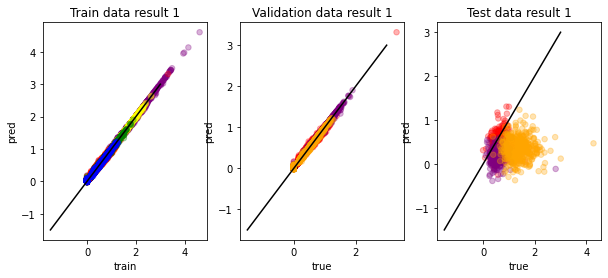

Epoch  4600 Train_loss:  0.013121371  Validation_loss:  0.013259046  Test_loss:  0.80178225
Epoch  4700 Train_loss:  0.012312748  Validation_loss:  0.01249185  Test_loss:  0.8016384
Epoch  4800 Train_loss:  0.011564252  Validation_loss:  0.011787638  Test_loss:  0.8015351
Epoch  4900 Train_loss:  0.010861954  Validation_loss:  0.011116024  Test_loss:  0.8017934
Epoch  5000 Train_loss:  0.010213353  Validation_loss:  0.010508165  Test_loss:  0.80163234


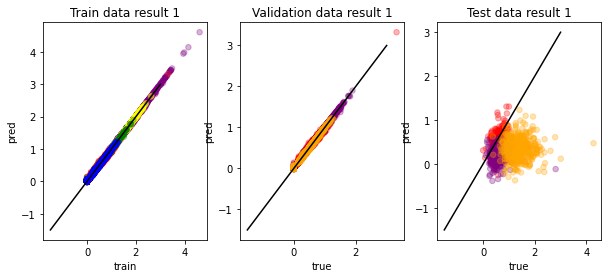

Epoch  5100 Train_loss:  0.009608141  Validation_loss:  0.0099228015  Test_loss:  0.8018503
Epoch  5200 Train_loss:  0.009045471  Validation_loss:  0.009391994  Test_loss:  0.8017631
Epoch  5300 Train_loss:  0.008521528  Validation_loss:  0.008891259  Test_loss:  0.8017149
Epoch  5400 Train_loss:  0.008035554  Validation_loss:  0.008417619  Test_loss:  0.80160236
Epoch  5500 Train_loss:  0.0075757806  Validation_loss:  0.0079804845  Test_loss:  0.8018498


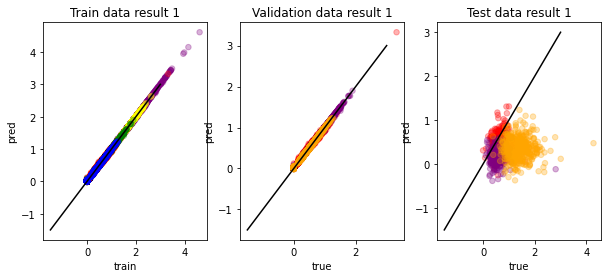

Epoch  5600 Train_loss:  0.0071499497  Validation_loss:  0.007568733  Test_loss:  0.80184036
Epoch  5700 Train_loss:  0.006751744  Validation_loss:  0.00718187  Test_loss:  0.80173653
Epoch  5800 Train_loss:  0.0063788155  Validation_loss:  0.0068193236  Test_loss:  0.8017864
Epoch  5900 Train_loss:  0.006032736  Validation_loss:  0.0064797876  Test_loss:  0.80197644
Epoch  6000 Train_loss:  0.0057009025  Validation_loss:  0.006155782  Test_loss:  0.8019245


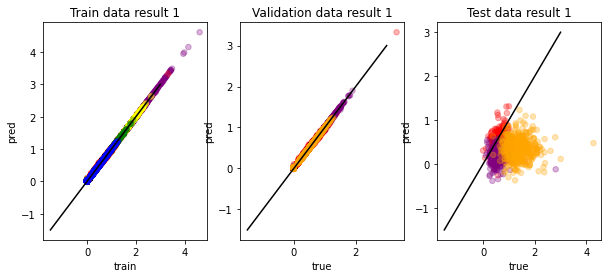

Epoch  6100 Train_loss:  0.0053955144  Validation_loss:  0.0058544115  Test_loss:  0.8020401
Epoch  6200 Train_loss:  0.005107902  Validation_loss:  0.0055705965  Test_loss:  0.80185044
Epoch  6300 Train_loss:  0.004840616  Validation_loss:  0.0053044064  Test_loss:  0.8017751
Epoch  6400 Train_loss:  0.004583453  Validation_loss:  0.0050491984  Test_loss:  0.8019243
Epoch  6500 Train_loss:  0.00434814  Validation_loss:  0.0048098145  Test_loss:  0.80178255


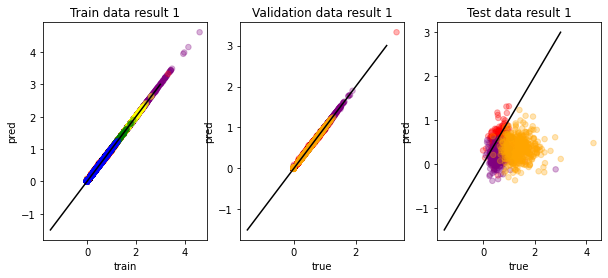

Epoch  6600 Train_loss:  0.0041201105  Validation_loss:  0.0045806644  Test_loss:  0.801951
Epoch  6700 Train_loss:  0.0039091366  Validation_loss:  0.004369901  Test_loss:  0.80194414
Epoch  6800 Train_loss:  0.0037125195  Validation_loss:  0.004167433  Test_loss:  0.8020641
Epoch  6900 Train_loss:  0.003523654  Validation_loss:  0.003974546  Test_loss:  0.8020434
Epoch  7000 Train_loss:  0.0033497065  Validation_loss:  0.003797752  Test_loss:  0.8018284


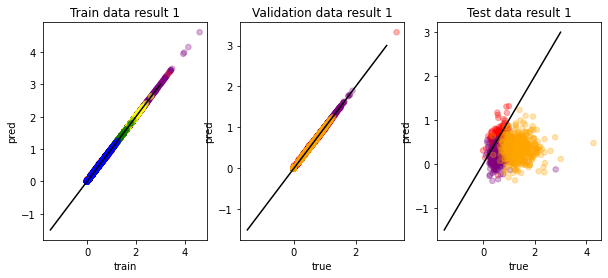

Epoch  7100 Train_loss:  0.0031819637  Validation_loss:  0.0036269925  Test_loss:  0.8018382
Epoch  7200 Train_loss:  0.0030235464  Validation_loss:  0.0034583318  Test_loss:  0.80186385
Epoch  7300 Train_loss:  0.0028777171  Validation_loss:  0.0033045793  Test_loss:  0.80200976
Epoch  7400 Train_loss:  0.0027336616  Validation_loss:  0.0031583742  Test_loss:  0.8019509
Epoch  7500 Train_loss:  0.0026019001  Validation_loss:  0.0030167173  Test_loss:  0.8019614


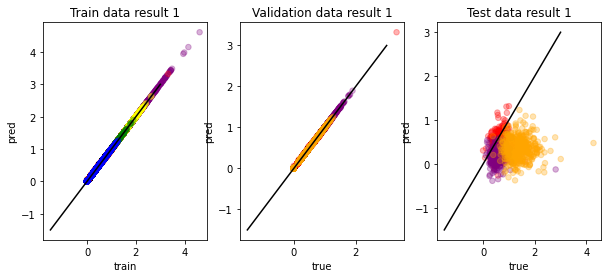

Epoch  7600 Train_loss:  0.00247635  Validation_loss:  0.0028861624  Test_loss:  0.8019603
Epoch  7700 Train_loss:  0.0023599954  Validation_loss:  0.002760573  Test_loss:  0.80192524
Epoch  7800 Train_loss:  0.0022523757  Validation_loss:  0.0026439775  Test_loss:  0.80181533
Epoch  7900 Train_loss:  0.0021400875  Validation_loss:  0.0025274877  Test_loss:  0.8019306
Epoch  8000 Train_loss:  0.0020403992  Validation_loss:  0.002422076  Test_loss:  0.8019465


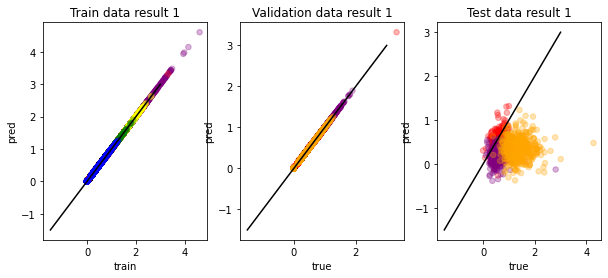

Epoch  8100 Train_loss:  0.0019454877  Validation_loss:  0.002319324  Test_loss:  0.80192184
Epoch  8200 Train_loss:  0.0018583629  Validation_loss:  0.0022211964  Test_loss:  0.8019945
Epoch  8300 Train_loss:  0.0017730735  Validation_loss:  0.0021256784  Test_loss:  0.80204374
Epoch  8400 Train_loss:  0.0016896809  Validation_loss:  0.002037564  Test_loss:  0.80197054
Epoch  8500 Train_loss:  0.0016135339  Validation_loss:  0.0019534165  Test_loss:  0.80195504


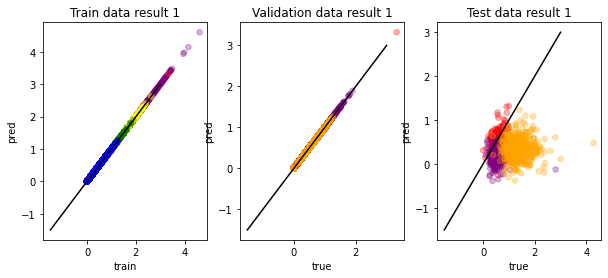

Epoch  8600 Train_loss:  0.0015399862  Validation_loss:  0.001873853  Test_loss:  0.8019805
Epoch  8700 Train_loss:  0.0014735647  Validation_loss:  0.0017978173  Test_loss:  0.801907
Epoch  8800 Train_loss:  0.0014054778  Validation_loss:  0.0017227917  Test_loss:  0.8019651
Epoch  8900 Train_loss:  0.0013447179  Validation_loss:  0.001652533  Test_loss:  0.8019551
Epoch  9000 Train_loss:  0.001291214  Validation_loss:  0.0015930983  Test_loss:  0.8018534


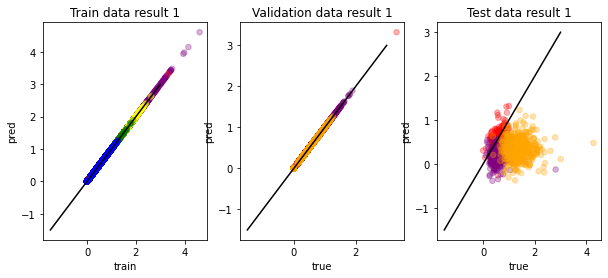

Epoch  9100 Train_loss:  0.0012278778  Validation_loss:  0.0015238095  Test_loss:  0.8019815
Epoch  9200 Train_loss:  0.0011781739  Validation_loss:  0.0014629664  Test_loss:  0.8019683
Epoch  9300 Train_loss:  0.0011248252  Validation_loss:  0.0014034872  Test_loss:  0.8019686
Epoch  9400 Train_loss:  0.0010797894  Validation_loss:  0.0013487134  Test_loss:  0.8020169
Epoch  9500 Train_loss:  0.0010337088  Validation_loss:  0.0012952148  Test_loss:  0.8020244


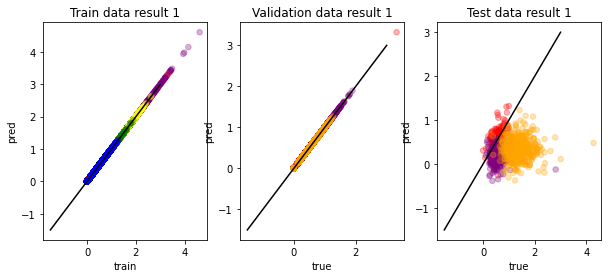

Epoch  9600 Train_loss:  0.0009954267  Validation_loss:  0.0012439995  Test_loss:  0.80205935
Epoch  9700 Train_loss:  0.0009774982  Validation_loss:  0.0012081452  Test_loss:  0.8021772
Epoch  9800 Train_loss:  0.0009133215  Validation_loss:  0.0011474767  Test_loss:  0.8020639
Epoch  9900 Train_loss:  0.0008698504  Validation_loss:  0.0011179318  Test_loss:  0.80191684


In [51]:
num_epochs = 10000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)